## Initialisation of different libraries

In [1]:
#initialization

# import basic math tools
# import itertools as it
import time
from scipy.sparse import csr_matrix
import scipy
import matplotlib.pyplot as plt
import numpy as np
pi = np.pi
import math

# import qtda module
import qtda_module as qtda

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
import qiskit.extensions
# import basic plot tools
from qiskit.visualization import plot_histogram

## Define combinatorial laplacian

In [2]:
n_vertices = 3
S0 = [(0,0,1),(0,1,0), (1,0,0)]
S_test = [(0,1,0,0),(0,0,1,1)]
S1 = [(0,1,1),(1,1,0),(1,0,1)]
S2 = []
#S2 = [(1,1,1)]
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

### Example for a combinatorial Laplacian

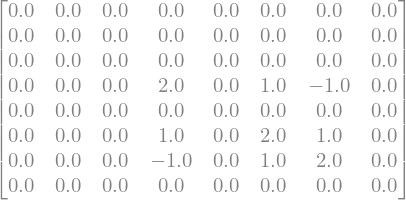

In [4]:
from sympy import Matrix, init_printing
init_printing()

display(Matrix(qtda.projected_combinatorial_laplacian(3, 1, state_dict).toarray()))

## QPE is defined

In [5]:
def controledU(U, qc, num_qubits, n_vertices):#, k, state_dict):
    unit = U
#     unit = scipy.linalg.expm(1j*qtda.projected_combinatorial_laplacian(n_vertices, k, state_dict).toarray())
    gate = qiskit.extensions.UnitaryGate(unit)
    for counting_qubit in range(num_qubits):
        qc.append(gate.control(1), [counting_qubit] + list(range(num_qubits,num_qubits+n_vertices)))
        unit = unit@unit
        gate = gate = qiskit.extensions.UnitaryGate(unit)
    return qc


In [6]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [7]:
def qpe_total(num_qubits, n_vertices, unitary): #, k, state_dict):
    qc = QuantumCircuit(num_qubits + n_vertices)
    for qubit in range(num_qubits):
        qc.h(qubit)
    controledU(unitary, qc, num_qubits, n_vertices) #, k, state_dict)
    # Apply inverse QFT
    qft_dagger(qc, num_qubits)
    return qc

## Initialize input state

0.7193536758422852


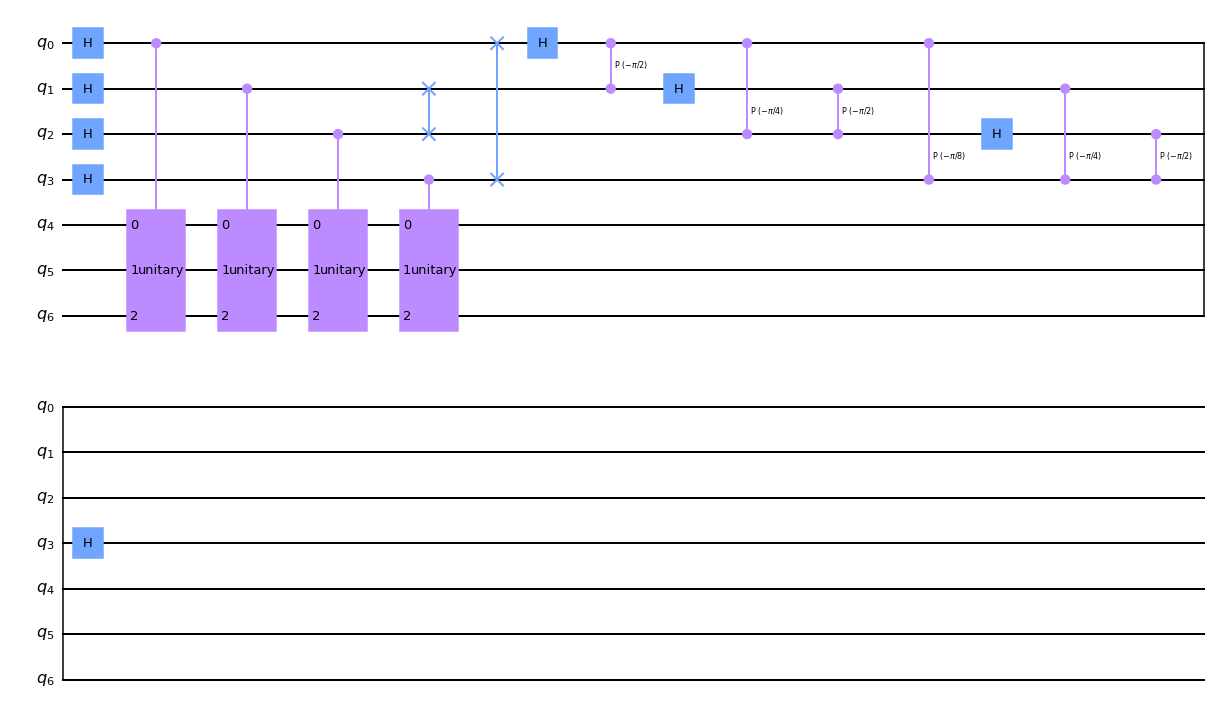

In [8]:
num_qubits = 4
k = 1

unitary = scipy.linalg.expm(
    1j*qtda.projected_combinatorial_laplacian(n_vertices, k, state_dict).toarray()
    )
t = time.time()
qpe = qpe_total(num_qubits, n_vertices, unitary)
print(time.time() - t)
qpe.draw('mpl')

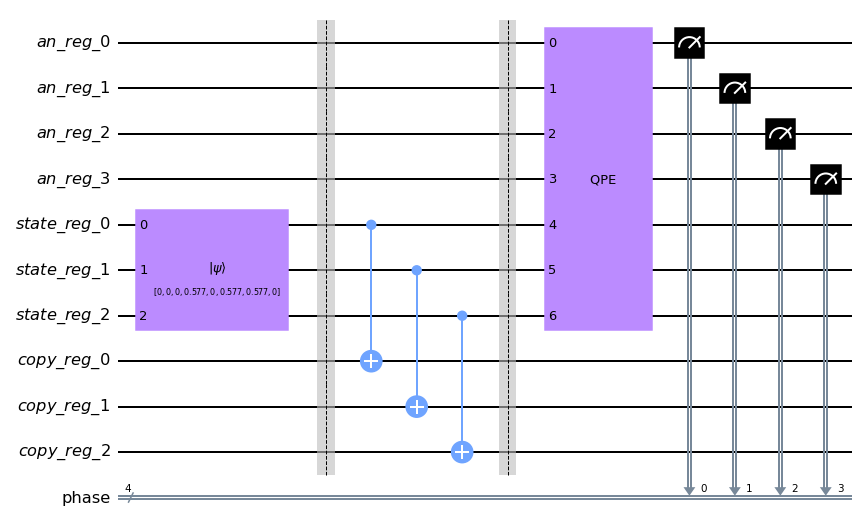

In [27]:
num_qubits = 4
k = 1

# qpe = qpe_total(num_qubits, n_vertices, k, state_dict)

qc = qtda.initialize_projector(
    state_dict[1],
    circuit=qpe,
    initialization_qubits=list(range(num_qubits,num_qubits+n_vertices)),
    circuit_name='        QPE        '
    )
qc.add_register(ClassicalRegister(num_qubits, name="phase"))
for k in range(num_qubits):
    qc.measure(k,k)
qc.draw('mpl')

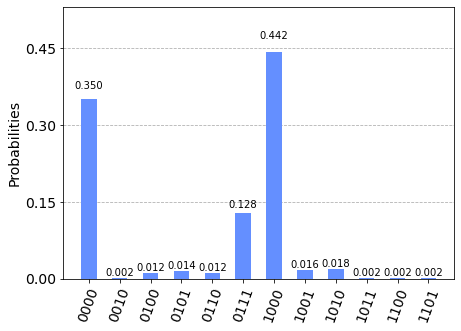

In [33]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=500)
data = job.result().get_counts(qc)
plot_histogram(data)

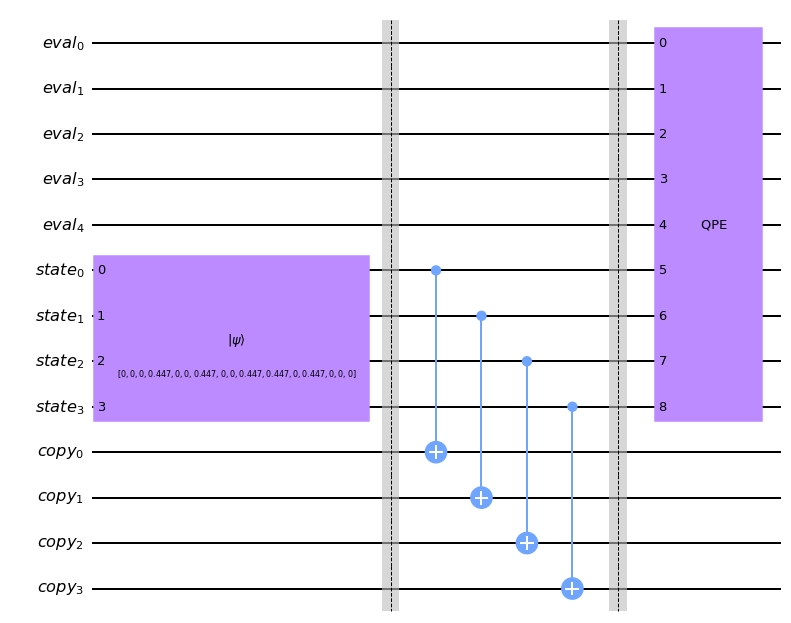

In [3]:
n_vertices = 4
num_qubits = 5
shots = 2000

S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
S2 = []
S2 = [(1,0,1,1)]
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

k = 1
qc = qtda.QTDA_algorithm(num_qubits, k, state_dict)
qc.draw('mpl')

# The full analysis for all k

## Filtration of data cloud

In [4]:
point_data = np.array([
    [0.,0.],
    [1.,0.],
    [1.,1.],
    [0.,1.],
    ])

point_data = np.array([
    [0.,0.],
    [1.,0.],
    [1.,1.]
    ])

distance_matrix = scipy.spatial.distance_matrix(point_data, point_data)

shots = 1000
num_eval_qubits = 10
# epsilons = [0.1, 1.1, 1.5]

data = qtda.Q_persistent_top_spectra(
    data = point_data,
#     distance_matrix=distance_matrix, 
    max_dimension=2, 
    max_edge_length=4, 
    num_eval_qubits=num_eval_qubits, 
    shots=shots)


Filtration scale:  0.0

Topological order:  0
3.8747360706329346
6.751266717910767
Topological order:  1
calculation terminated because no simplex of size ...

Filtration scale:  1.0

Topological order:  0
2.521850824356079
3.291749954223633
Topological order:  1
1.618157148361206
2.0440330505371094
Topological order:  2
calculation terminated because no simplex of size ...

Filtration scale:  1.4142135623730951

Topological order:  0
0.36720800399780273
0.05026674270629883
Topological order:  1
1.981645107269287
3.252685070037842
Topological order:  2
calculation terminated because no simplex of size ...


In [5]:
eigenvalue_dict = data.get_eigenvalues()
for eps in eigenvalue_dict.keys():
    print()
    print()
    print('Filtration scale: ', eps)
    for top_order in eigenvalue_dict[eps].keys():
        print()
        print('Topological order: ', top_order)
        print('Number of holes: ', eigenvalue_dict[eps][top_order][0.0])
        print('Eigenvalues with dimension of corresponding eigenspaces: ')
        print(eigenvalue_dict[eps][top_order])
#         display(plot_histogram(data.get_counts()[eps][top_order]))

3
3
2
3
3


Filtration scale:  0.0

Topological order:  0
Number of holes:  2.022
Eigenvalues with dimension of corresponding eigenspaces: 
{0.0: 2.022, 3.722004199560928: 0.96}


Filtration scale:  1.0

Topological order:  0
Number of holes:  0
Eigenvalues with dimension of corresponding eigenspaces: 
{0.0: 0, 4.839833843653484: 0.984, 3.722004199560928: 1.98}

Topological order:  1
Number of holes:  0
Eigenvalues with dimension of corresponding eigenspaces: 
{0.0: 0, 3.722004199560928: 1.004, 4.839833843653484: 0.976}


Filtration scale:  1.4142135623730951

Topological order:  0
Number of holes:  0
Eigenvalues with dimension of corresponding eigenspaces: 
{0.0: 0, 3.722004199560928: 2.952}

Topological order:  1
Number of holes:  0.984
Eigenvalues with dimension of corresponding eigenspaces: 
{0.0: 0.984, 3.722004199560928: 1.977}


## Homology of simple examples

### with QTDA_algoritm

In [4]:
def full_topological_analysis_2(num_qubits, n_vertices, state_dict, shots):
    
    for k in range(n_vertices):
        if (len(state_dict[k])==0):
            print("calculation terminated because no simplex of size ...")
            break

        t = time.time()
        
        qc = qtda.QTDA_algorithm(num_qubits, k, state_dict)
        
        print(time.time() - t)
        
        qc.add_register(ClassicalRegister(num_qubits, name="phase"))
        for q in qc.eval_qubits:
            qc.measure(q,q)
        
        backend = Aer.get_backend('qasm_simulator')
        
        t = time.time()
        
        job = execute(qc, backend, shots=shots)
        data = job.result().get_counts(qc)
        
        print(time.time() - t)
        print()
        print("\033[1m Loop k = %s. \033[0m The histogram is:" %(k))
#         print("Loop k = %s. The histogram is:" %(k))
        display(plot_histogram(data))
        #plt.bar(list(data.keys()), data.values(), color='g')
        #plt.show()
        value = data.get("0"*num_qubits)
        if(value==None):
            value=0
        print("Number of shots: "+str(shots))
        print("state dict: "+str(state_dict))
        print("Number of counts for 0000: "+str(value))
        print("Length of state dict k: "+str(len(state_dict[k])))
        print("'\033[1m'Total count of holes: %s '\033[0m'" % (value*len(state_dict[k])/shots))
        print("\n")
        print("\n")

0.5427432060241699
0.12848925590515137

 Loop k = 0.  The histogram is:


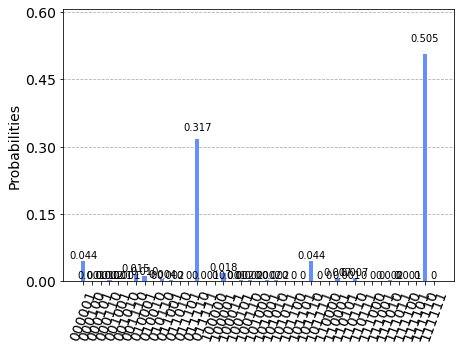

Number of shots: 2000
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1), (1, 1, 0), (1, 0, 1)], 2: [], 3: []}
Number of counts for 0000: 0
Length of state dict k: 3
''Total count of holes: 0.0 ''




2.522412061691284
3.3901238441467285

 Loop k = 1.  The histogram is:


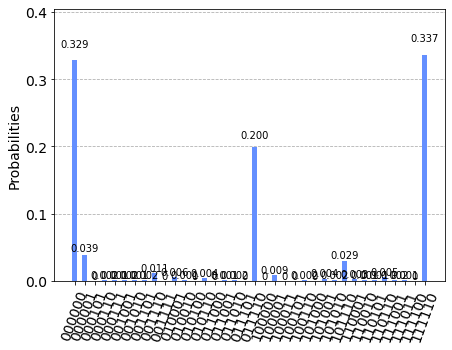

Number of shots: 2000
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1), (1, 1, 0), (1, 0, 1)], 2: [], 3: []}
Number of counts for 0000: 657
Length of state dict k: 3
''Total count of holes: 0.9855 ''




calculation terminated because no simplex of size ...


In [6]:
def example1():
    n_vertices = 3
    num_qubits = 6
    shots = 2000

    S0 = [(0,0,1),(0,1,0), (1,0,0)]
    S1 = [(0,1,1),(1,1,0),(1,0,1)]
    S2 = []
#     S2 = [(1,1,1)]
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    qpe = QuantumCircuit(num_qubits + n_vertices)

    full_topological_analysis_2(num_qubits, n_vertices, state_dict, shots)
    
example1()

9.130433082580566
10.85637092590332

 Loop k = 0.  The histogram is:


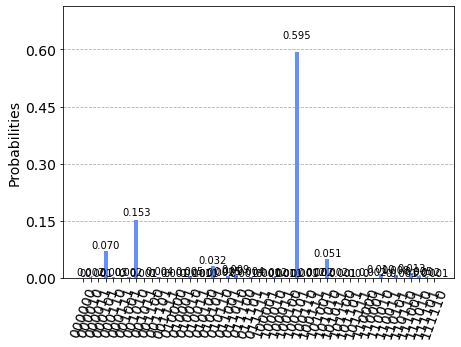

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 1, 1, 0), (1, 1, 0, 1)], 3: []}
Number of counts for 0000: 1
Length of state dict k: 4
''Total count of holes: 0.002 ''




14.398787260055542
22.958066940307617

 Loop k = 1.  The histogram is:


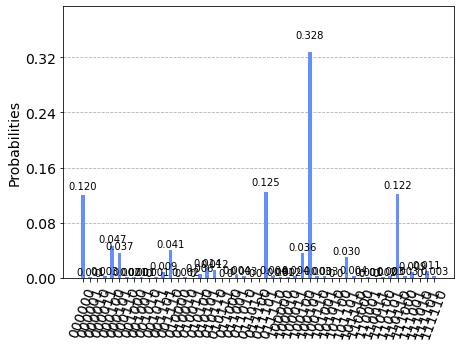

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 1, 1, 0), (1, 1, 0, 1)], 3: []}
Number of counts for 0000: 241
Length of state dict k: 5
''Total count of holes: 0.6025 ''




4.175262928009033
2.375606060028076

 Loop k = 2.  The histogram is:


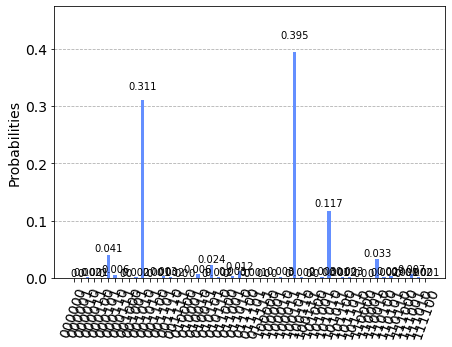

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 1, 1, 0), (1, 1, 0, 1)], 3: []}
Number of counts for 0000: 1
Length of state dict k: 2
''Total count of holes: 0.001 ''




calculation terminated because no simplex of size ...


In [9]:
def example2holes():

    n_vertices = 4
    num_qubits = 6
    shots = 2000

    S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
    S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
    S2 = []
    S2 = [(1,1,1,0),(1,1,0,1)]
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    full_topological_analysis_2(num_qubits, n_vertices, state_dict, shots)

example2holes()

### Building QPE by parts

In [10]:
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import PhaseEstimation

def full_topological_analysis(num_qubits, n_vertices, state_dict, shots):
    
    for k in range(n_vertices):
        if (len(state_dict[k])==0):
            print("calculation terminated because no simplex of size ...")
            break
        
        unitary = scipy.linalg.expm(
            1j*qtda.projected_combinatorial_laplacian(n_vertices, k, state_dict).toarray()
            )

        t = time.time()
        
#         qpe = qpe_total(num_qubits, n_vertices, unitary)
        
        gate = UnitaryGate(unitary)
        qpe = PhaseEstimation(num_qubits, unitary=gate, iqft=None, name='QPE')

        qc = qtda.initialize_projector(
            state_dict[k],
            circuit=qpe,
            initialization_qubits=list(range(num_qubits,num_qubits+n_vertices)),
            circuit_name='        QPE        '
            )
        
        print(time.time() - t)
        
        qc.add_register(ClassicalRegister(num_qubits, name="phase"))
        for j in range(num_qubits):
            qc.measure(j,j)
#         qc.draw('mpl')
        
        backend = Aer.get_backend('qasm_simulator')
        
        t = time.time()
        
        job = execute(qc, backend, shots=shots)
        data = job.result().get_counts(qc)
        
        print(time.time() - t)
        print()
        print("\033[1m Loop k = %s. \033[0m The histogram is:" %(k))
#         print("Loop k = %s. The histogram is:" %(k))
        display(plot_histogram(data))
        #plt.bar(list(data.keys()), data.values(), color='g')
        #plt.show()
        value = data.get("0"*num_qubits)
        if(value==None):
            value=0
        print("Number of shots: "+str(shots))
        print("state dict: "+str(state_dict))
        print("Number of counts for 0000: "+str(value))
        print("Length of state dict k: "+str(len(state_dict[k])))
        print("'\033[1m'Total count of holes: %s '\033[0m'" % (value*len(state_dict[k])/shots))
        print("\n")
        print("\n")

0.1553950309753418
0.027827978134155273

 Loop k = 0.  The histogram is:


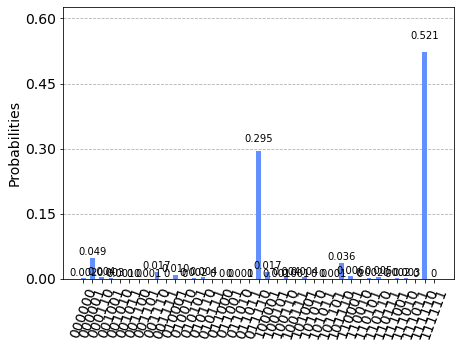

Number of shots: 2000
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1), (1, 1, 0), (1, 0, 1)], 2: [], 3: []}
Number of counts for 0000: 3
Length of state dict k: 3
''Total count of holes: 0.0045 ''




1.7815799713134766
1.885110855102539

 Loop k = 1.  The histogram is:


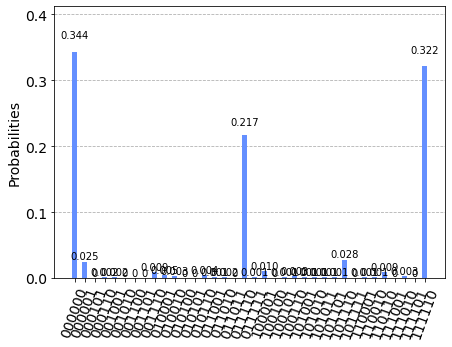

Number of shots: 2000
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1), (1, 1, 0), (1, 0, 1)], 2: [], 3: []}
Number of counts for 0000: 687
Length of state dict k: 3
''Total count of holes: 1.0305 ''




calculation terminated because no simplex of size ...


In [11]:
def example1():
    n_vertices = 3
    num_qubits = 6
    shots = 2000

    S0 = [(0,0,1),(0,1,0), (1,0,0)]
    S1 = [(0,1,1),(1,1,0),(1,0,1)]
    S2 = []
#     S2 = [(1,1,1)]
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    qpe = QuantumCircuit(num_qubits + n_vertices)

    full_topological_analysis(num_qubits, n_vertices, state_dict, shots)
    
example1()

Two holes on a 4 point simplicial complex

7.223412990570068
9.72762131690979

 Loop k = 0.  The histogram is:


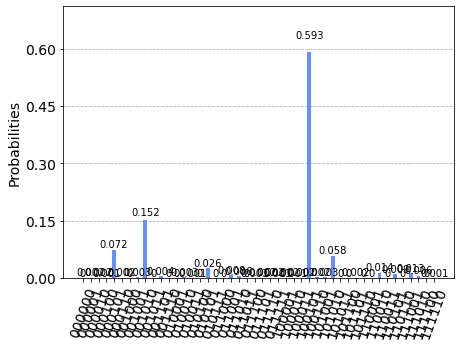

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [], 3: []}
Number of counts for 0000: 1
Length of state dict k: 4
''Total count of holes: 0.002 ''




10.792651891708374
15.29193902015686

 Loop k = 1.  The histogram is:


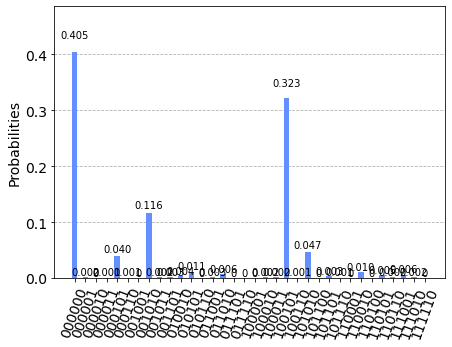

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [], 3: []}
Number of counts for 0000: 809
Length of state dict k: 5
''Total count of holes: 2.0225 ''




calculation terminated because no simplex of size ...


In [12]:
def example2holes():

    n_vertices = 4
    num_qubits = 6
    shots = 2000

    S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
    S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
    S2 = []
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    full_topological_analysis(num_qubits, n_vertices, state_dict, shots)

example2holes()
    

Loop k = 0. The dictionary of the data is:
{'011111': 1, '000010': 1, '001111': 4, '011000': 2, '011010': 1, '000001': 2, '010011': 26, '001110': 3, '000011': 3, '000000': 5, '011101': 3, '000110': 13, '010110': 26, '010101': 110, '000101': 7, '011110': 1, '010100': 328, '000111': 25, '001011': 15, '010010': 13, '010000': 2, '011001': 9, '001100': 8, '000100': 4, '001010': 41, '010111': 6, '001101': 10, '001000': 131, '010001': 7, '011011': 1, '001001': 1192}
Loop k = 0. The histogram is:


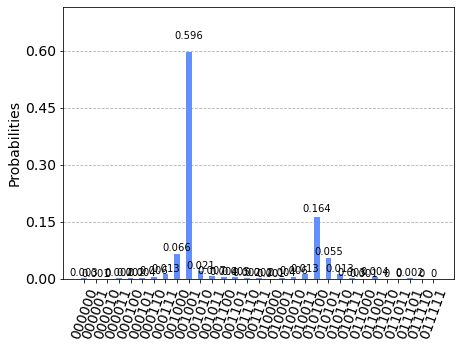

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 1, 1, 0)], 3: []}
Number of counts for 0000: 5
Length of state dict k: 4
Total count of holes: 0.01 




Loop k = 1. The dictionary of the data is:
{'001111': 1, '001100': 4, '011100': 9, '010000': 1, '011001': 4, '011010': 3, '000001': 11, '000011': 4, '011000': 3, '000010': 9, '010010': 5, '001011': 8, '001010': 25, '001101': 3, '010111': 5, '001110': 2, '010011': 19, '010001': 6, '001000': 71, '000111': 16, '010100': 246, '000100': 5, '010110': 14, '011111': 206, '011101': 19, '000110': 15, '011110': 128, '000101': 2, '010101': 87, '011011': 3, '001001': 641, '000000': 425}
Loop k = 1. The histogram is:


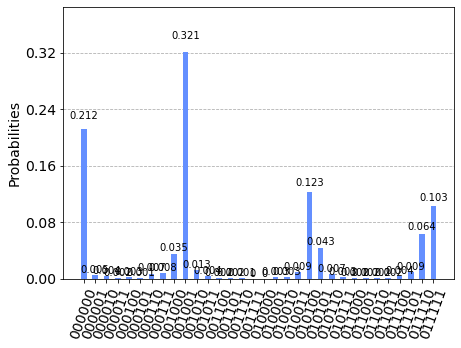

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 1, 1, 0)], 3: []}
Number of counts for 0000: 425
Length of state dict k: 5
Total count of holes: 1.0625 




Loop k = 2. The dictionary of the data is:
{'001100': 1, '001011': 2, '010011': 2, '001110': 1, '000100': 2, '001111': 2, '010010': 2, '010101': 2, '000101': 7, '011000': 6, '010001': 4, '001000': 6, '011011': 20, '000011': 17, '011010': 11, '000001': 36, '011001': 11, '010000': 2, '000110': 5, '011101': 77, '000010': 8, '000000': 94, '010100': 1, '000111': 3, '011110': 630, '001010': 4, '001101': 2, '010111': 3, '011100': 35, '010110': 6, '011111': 998}
Loop k = 2. The histogram is:


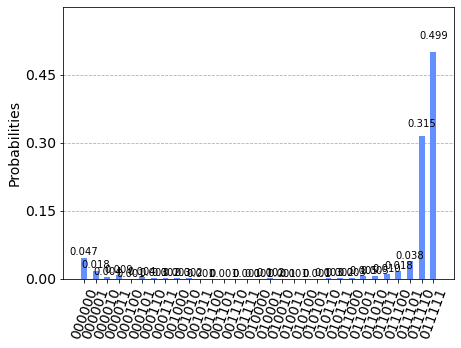

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0)], 2: [(1, 1, 1, 0)], 3: []}
Number of counts for 0000: 94
Length of state dict k: 1
Total count of holes: 0.047 




calculation terminated because no simplex of size ...


In [70]:
def example1hole():

    n_vertices = 4
    num_qubits = 6
    shots = 2000

    S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
    S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
    S2 = [(1,1,1,0)]
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    full_topological_analysis(num_qubits, n_vertices, state_dict, shots)
    
example1hole()

Loop k = 0. The dictionary of the data is:
{'010110': 2, '010010': 2, '000000': 1, '000101': 8, '010101': 2, '000111': 45, '010100': 3, '010000': 3, '011001': 3, '010111': 2, '001101': 2, '001111': 1, '000011': 5, '011010': 1, '000001': 3, '011111': 1, '000110': 14, '000010': 3, '001010': 71, '011100': 3, '001011': 27, '010011': 1, '001110': 5, '000100': 5, '001100': 10, '001000': 179, '011110': 1, '001001': 1597}
Loop k = 0. The histogram is:


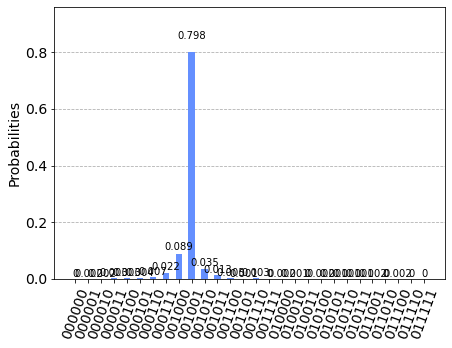

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (0, 1, 0, 1)], 2: [(1, 0, 1, 1), (1, 1, 1, 0), (1, 1, 0, 1)], 3: [], 4: []}
Number of counts for 0000: 1
Length of state dict k: 4
''Total count of holes: 0.002 ''




Loop k = 1. The dictionary of the data is:
{'000001': 2, '010001': 2, '000100': 5, '000011': 1, '000010': 3, '000111': 31, '010100': 3, '000000': 6, '010011': 3, '001110': 5, '010000': 1, '011001': 1, '000110': 20, '011101': 3, '000101': 7, '001111': 4, '001101': 4, '011111': 2, '010110': 2, '001010': 329, '011011': 2, '001001': 1336, '001011': 35, '010010': 6, '001100': 11, '001000': 176}
Loop k = 1. The histogram is:


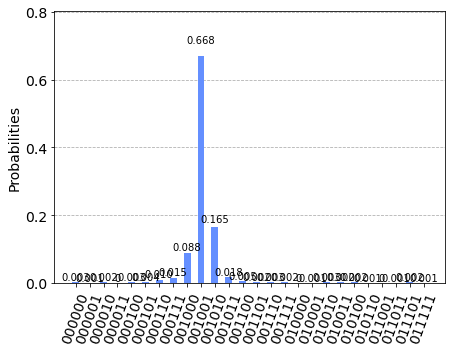

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (0, 1, 0, 1)], 2: [(1, 0, 1, 1), (1, 1, 1, 0), (1, 1, 0, 1)], 3: [], 4: []}
Number of counts for 0000: 6
Length of state dict k: 6
''Total count of holes: 0.018 ''




Loop k = 2. The dictionary of the data is:
{'000000': 2, '011110': 1, '011100': 1, '000011': 3, '011000': 1, '010011': 4, '001110': 3, '010010': 2, '000010': 2, '010000': 4, '011001': 1, '000110': 15, '011101': 1, '010110': 1, '001100': 12, '000100': 3, '001111': 4, '001101': 11, '010101': 2, '000101': 3, '010001': 2, '001000': 131, '010100': 1, '000111': 27, '001001': 1078, '011010': 2, '001011': 50, '001010': 633}
Loop k = 2. The histogram is:


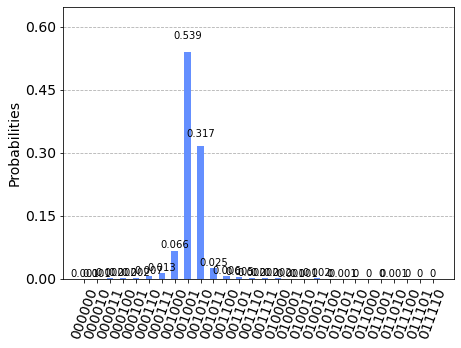

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (0, 1, 0, 1)], 2: [(1, 0, 1, 1), (1, 1, 1, 0), (1, 1, 0, 1)], 3: [], 4: []}
Number of counts for 0000: 2
Length of state dict k: 3
''Total count of holes: 0.003 ''




calculation terminated because no simplex of size ...


In [87]:
def example0holes():

    n_vertices = 4
    num_qubits = 6
    shots = 2000

    S0 = [(0,0,0,1),(0,0,1,0),(0,1,0,0),(1,0,0,0)]
    S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0),(0,1,0,1)]
    S2 = [(1,0,1,1),(1,1,1,0),(1,1,0,1),(0,1,1,1)]
    S3 = []
    S4 = []
    
    
    state_dict = {0: S0, 1: S1, 2: S2, 3: S3, 4: S4}

    full_topological_analysis(num_qubits, n_vertices, state_dict, shots)
    
example0holes()

Loop k = 0. The dictionary of the data is:
{'00101': 1, '00111': 1, '00010': 4, '01111': 147, '01101': 4, '01001': 5, '01100': 2, '00100': 1, '00011': 2, '00001': 1, '01110': 6, '01011': 10, '00000': 165, '01010': 151}
Loop k = 0. The histogram is:


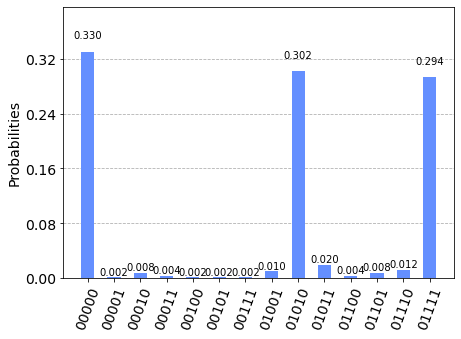

Number of shots: 500
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1)], 2: []}
Number of counts for 0000: 165
Length of state dict k: 3
''Total count of holes: 0.99 ''




Loop k = 1. The dictionary of the data is:
{'00111': 1, '00010': 1, '01101': 1, '00101': 1, '00110': 2, '01010': 446, '01001': 10, '01000': 1, '01110': 1, '01100': 9, '01011': 27}
Loop k = 1. The histogram is:


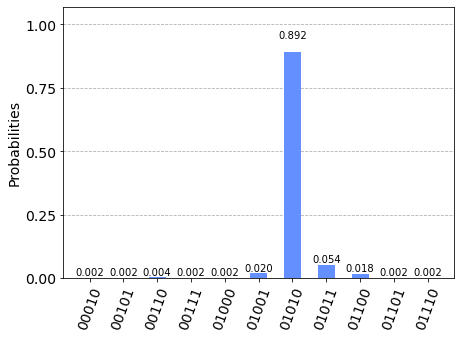

Number of shots: 500
state dict: {0: [(0, 0, 1), (0, 1, 0), (1, 0, 0)], 1: [(0, 1, 1)], 2: []}
Number of counts for 0000: 0
Length of state dict k: 1
''Total count of holes: 0.0 ''




calculation terminated because no simplex of size ...


In [89]:
def example4():

    n_vertices = 3
    num_qubits = 5
    shots = 500

    S0 = [(0,0,1), (0,1,0), (1,0,0)]
    S1 = [(0,1,1)]
    S2 = []

    state_dict = {0: S0, 1: S1, 2: S2}

    full_topological_analysis(num_qubits, n_vertices, state_dict, shots)
    
example4()

Loop k = 0. The dictionary of the data is:
{'000100': 2, '011111': 1, '011010': 1, '000001': 2, '011100': 1, '001011': 12, '011011': 3, '011000': 5, '000000': 3, '010101': 239, '000101': 9, '011001': 6, '010000': 4, '000110': 9, '011101': 1, '001100': 3, '010010': 14, '001101': 2, '010111': 9, '001010': 36, '001111': 2, '001110': 3, '010011': 46, '010100': 598, '000111': 18, '011110': 6, '000011': 2, '010001': 10, '001000': 102, '010110': 36, '001001': 815}
Loop k = 0. The histogram is:


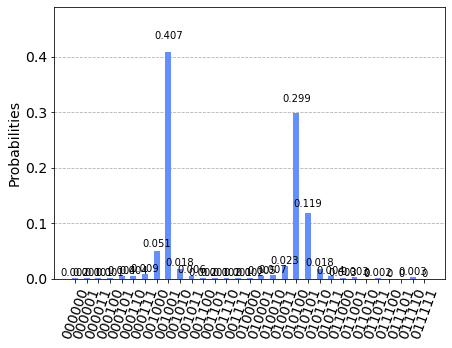

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1)], 2: [], 3: []}
Number of counts for 0000: 3
Length of state dict k: 4
Total count of holes: 0.006 




Loop k = 1. The dictionary of the data is:
{'011111': 1, '011011': 3, '011010': 1, '011100': 2, '001111': 8, '000011': 1, '010011': 56, '001110': 3, '011110': 3, '010100': 625, '000111': 14, '011000': 9, '000110': 3, '011101': 2, '010000': 6, '011001': 7, '000100': 3, '001100': 5, '001010': 10, '001101': 2, '010111': 12, '010001': 8, '001000': 51, '000101': 6, '010101': 226, '000000': 502, '010110': 35, '001001': 368, '010010': 18, '001011': 10}
Loop k = 1. The histogram is:


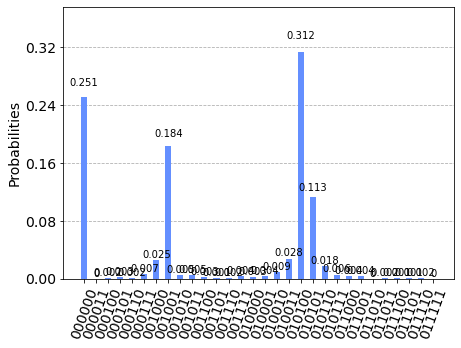

Number of shots: 2000
state dict: {0: [(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)], 1: [(0, 0, 1, 1), (0, 1, 1, 0), (1, 1, 0, 0), (1, 0, 0, 1)], 2: [], 3: []}
Number of counts for 0000: 502
Length of state dict k: 4
Total count of holes: 1.004 




calculation terminated because no simplex of size ...


In [71]:
def ndexample1hole():

    n_vertices = 4
    num_qubits = 6
    shots = 2000

    S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
    S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1)]
    S2 = []
    S3 = []

    state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

    full_topological_analysis(num_qubits, n_vertices, state_dict, shots)
    
ndexample1hole()

In [ ]:
def run_circuit(circuit):
    qasm_sim = Aer.get_backend('qasm_simulator')
    shots = 2048
    job = execute(circuit, qasm_sim, shots=1024)
    answer = job.result().get_counts(qc)
    return answer

In [ ]:
answer = run_circuit(qc)
print(answer)
plot_histogram(answer)